# Project Fletcher

*Project 4 of Metis Data Science Bootcamp*: Use NLP and clustering methods to find patterns in corpora of your choice.

I analyzed all the text from the Harry Potter series using tf-idf, sentiment analysis, and LDA to determine how word importance and topics vary during character interactions throughout the series. For the purposes of this project, I define a character "interaction" as the mention of two character names within 50 words of each other (not including "stop-words"). Specifically, I focused on the storyline between the characters of Harry and Snape.

#### Data cleaning and preprocessing

In [10]:
import pandas as pd
import csv
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import itertools
from nltk.tokenize import word_tokenize
from textblob import TextBlob
import lda
import seaborn as sns
import matplotlib.pyplot as plt,mpld3
import mpld3
%matplotlib inline
from collections import defaultdict
from nltk.corpus import stopwords

In [11]:
stop = [str(s) for s in stopwords.words('english')]
punc = ['.', ',', '(', ')', "'", '"','...','?','!','-','--']
stop+=punc

Each book has slightly different formatting, these functions clean the text and split the book by chapter:

In [15]:
def read_book(book):
    b = csv.reader(open("book_text-files/{}.txt".format(book),"rb"))
    b = [[word.strip() for word in row] for row in b]
    b_lis = [y.replace("'",'').replace('\n',' ') for x in b for y in x]
    b_lis = ' '.join(b_lis)
    b_lis = b_lis.replace('\xe2\x80\x99',"'").replace('\xe2\x80\x9c','"').replace("'",'').replace('\xe2\x80\x9d','"')\
    .replace('\xe2\x80\xa6','...').replace('\xe2\x80\x94','-').replace('\xe2\x80\x98',"'").replace('\xe2\x80\xa2',' ')\
    .replace('\x0c','').replace('\xc2\xa6','').replace('\xc3\xa9','').replace('\xe2\x80\x93','')
    if book in ('book1','book2','book3','book4','book5'):
        b_lis = b_lis.split('CHAPTER ')
    elif book in ('book6','book7'):
        b_lis = b_lis.split('Chapter ')
    if book in ('book1','book2','book3','book6'):
        b_lis = [sentence[sentence.find(' '):] for sentence in b_lis[1:]]
    elif book in ('book4','book5'):
        b_lis = [sentence[sentence.find('- ')+1:] for sentence in b_lis[1:]]
    b_lis = [i.lower() for i in b_lis if not i.isdigit()]
    return b_lis

These data frames have the books separated by chapter:

In [16]:
book1 = pd.DataFrame(read_book('book1'),columns=['chapter'])
book2 = pd.DataFrame(read_book('book2'),columns=['chapter'])
book3 = pd.DataFrame(read_book('book3'),columns=['chapter'])
book4 = pd.DataFrame(read_book('book4'),columns=['chapter'])
book5 = pd.DataFrame(read_book('book5'),columns=['chapter'])
book6 = pd.DataFrame(read_book('book6'),columns=['chapter'])
book7 = pd.DataFrame(read_book('book7'),columns=['chapter'])

books = [book1,book2,book3,book4,book5,book6,book7]

Names and combinations for interaction analysis:

In [17]:
names = ['harry','ron','hermione','dumbledore','snape','malfoy','voldemort']

combos = list(itertools.combinations(names,2)) #all name combinations

Initializing data frames to hold character mention counts:

In [18]:
b1_df = pd.DataFrame(columns=combos,index=[i for i in range(len(book1))])
b2_df = pd.DataFrame(columns=combos,index=[i for i in range(len(book2))])
b3_df = pd.DataFrame(columns=combos,index=[i for i in range(len(book3))])
b4_df = pd.DataFrame(columns=combos,index=[i for i in range(len(book4))])
b5_df = pd.DataFrame(columns=combos,index=[i for i in range(len(book5))])
b6_df = pd.DataFrame(columns=combos,index=[i for i in range(len(book6))])
b7_df = pd.DataFrame(columns=combos,index=[i for i in range(len(book7))])

combo_dfs = [b1_df,b2_df,b3_df,b4_df,b5_df,b6_df,b7_df]

This function counts the number of times 2 character names appear within 50 (non-"stop") words of each other and adds them to a dataframe by book and chapter:

In [19]:
def get_counts(book,chap,name1,name2):
    words = [w for w in word_tokenize(books[book].iloc[chap,0]) if w not in stop if w.isalpha()==True]
    if name1 in words and name2 in words:
        name1_indexes = [index for index, value in enumerate(words) if value == name1]    
        name2_indexes = [index for index, value in enumerate(words) if value == name2]    
        distances = [abs(item[0] - item[1]) for item in itertools.product(name1_indexes, name2_indexes)]
        highest=[i for i in range(len(distances)) if distances[i]<50]
        combo_dfs[book].iloc[chap,combos.index((name1,name2))]=len(highest)
    else:
        combo_dfs[book].iloc[chap,combos.index((name1,name2))]=1        

Adding proximity counts to dataframes:

In [20]:
for b in range(len(books)):
    for chap in range(len(books[b])):
        for combo in combos:
            get_counts(b,chap,combo[0],combo[1])

#### Formatting nodes and edge weights for network graphs:

In [21]:
nodes = pd.Series(names)
nodes_dict = nodes.to_dict()

nodes_dict = dict(zip(nodes_dict.values(),nodes_dict.keys()))

nodes_df = nodes.reset_index()
nodes_df.columns = ['Id', 'name']

In [22]:
def get_edges(bookdf):    
    edges = bookdf.sum()
    edges_weights = edges.to_frame(name='Weight').reset_index()
    edges_weights.columns = ['Label', 'Weight']
    edges_weights['Source_Label'] = edges_weights.Label.apply(lambda x: x[0])
    edges_weights['Target_Label'] = edges_weights.Label.apply(lambda x: x[1])
    edges_weights['Source'] = edges_weights.Source_Label.apply(lambda x: nodes_dict.get(x))
    edges_weights['Target'] = edges_weights.Target_Label.apply(lambda x: nodes_dict.get(x))
    return edges_weights

Print JSON for network graph file:

In [27]:
def get_json(bookdf):    
    print '{ \n "nodes":['
    for i in range(len(nodes_df)):
        print '{' + '"name":"{}",'.format(nodes_df.iloc[i,1]) + '"group":{}'.format(i) + '},'
    print '],'
    print '"links":['
    for i in range(len(get_edges(bookdf))):
        print '{' + '"source":{},'.format(get_edges(bookdf).iloc[i,4]) + '"target":{},'.format(get_edges(bookdf).iloc[i,5]) + \
        '"value":{}'.format(int(get_edges(bookdf).iloc[i,1]) if int(get_edges(bookdf).iloc[i,1])>0 else 1) + '},' 
    print ']\n}'

#### Collecting TextBlob sentiment scores for each text segment mentioning "harry" and "snape":

This function returns only the text between positions where the 2 character names appear within 50 (non-"stop") words of each other spliced together:

In [28]:
def get_positions(book,chap,name1,name2):
    words = [w for w in word_tokenize(books[book].iloc[chap,0]) if w not in stop if w.isalpha()==True]
    if name1 in words and name2 in words:
        name1_indexes = [index for index, value in enumerate(words) if value == name1]    
        name2_indexes = [index for index, value in enumerate(words) if value == name2]    
        pairs=[(item[0],item[1]) for item in itertools.product(name1_indexes, name2_indexes) if abs(item[0] - item[1])<50]
        if pairs!=[]:
            return [x for y in [words[min(pairs[i]):max(pairs[i])+1] for i in range(len(pairs))] for x in y]
        else:
            return (0,0)
    else:
        return (0,0)   

In [29]:
sentiment = []
harrysnape = defaultdict(list)
for b in range(len(books)):
    for chap in range(len(books[b])):
        if get_positions(b,chap,'harry','snape')==(0,0):
            sentiment.append(0)
        else:
            sentiment.append(TextBlob(' '.join(get_positions(b,chap,'harry','snape'))).sentiment.polarity)
            harrysnape[b].append(' '.join(get_positions(b,chap,'harry','snape')))

#### Processing TF-IDF word rankings (for n-grams of size 1-6) for text segments between "harry" and "snape":

In [30]:
splice = []
splice+=[' '.join(v) for v in harrysnape.values()]

In [31]:
vectorizer = TfidfVectorizer(stop_words="english", ngram_range=(1,6))
doc_vectors = vectorizer.fit_transform(splice)
mat_array = doc_vectors.toarray()
fn = vectorizer.get_feature_names()

In [32]:
topwords  =pd.DataFrame()
for i,l in enumerate(mat_array): 
    topwords[i] = [(fn[x],l[x]) for x in (l*-1).argsort() if 'harry' not in fn[x].split() if 'snape' not in fn[x].split()][:80]

In [602]:
topwords.head()

,0,1,2,3,4,5,6
0,"(said, 0.128500219783)","(lockhart, 0.221442249935)","(said, 0.217404783758)","(said, 0.18246997201)","(said, 0.267451358039)","(said, 0.208577282171)","(said, 0.153654377978)"
1,"(quirrell, 0.127894804217)","(said, 0.161829858905)","(lupin, 0.126795896099)","(moody, 0.104223596652)","(sirius, 0.0786600207892)","(dumbledore, 0.103774903937)","(dumbledore, 0.072896495599)"
2,"(ron, 0.111711246344)","(ron, 0.102982637485)","(professor, 0.0702554899167)","(crouch, 0.0965284096529)","(potter, 0.0740634529953)","(professor, 0.0448663776099)","(wand, 0.0714671525481)"
3,"(hermione, 0.0962137324)","(malfoy, 0.0679006400999)","(ron, 0.0619575974068)","(dumbledore, 0.0870579625496)","(umbridge, 0.0543806769993)","(hagrid, 0.0445238861778)","(voldemort, 0.0616580706406)"
4,"(know, 0.0652187045127)","(justin, 0.0567108201054)","(potter, 0.0564256690669)","(karkaroff, 0.0853525352259)","(looked, 0.0484261038816)","(malfoy, 0.0434964118814)","(hermione, 0.0543150359365)"


Isolating tf-idf probabilities for "meaningful" words:

In [589]:
goodwords = pd.DataFrame(columns=[0,1,2,3,4])
goodwords.loc[0] = pd.Series([tup[1] for tup in topwords[0].iloc[[11,16,21,32,33]].values])
goodwords.loc[1] = pd.Series([tup[1] for tup in topwords[1].iloc[[6,8,10,17,42]].values])
goodwords.loc[2] = pd.Series([tup[1] for tup in topwords[2].iloc[[6,23,36,42,48]].values])
goodwords.loc[3] = pd.Series([tup[1] for tup in topwords[3].iloc[[11,15,21,32,37]].values])
goodwords.loc[4] = pd.Series([tup[1] for tup in topwords[4].iloc[[5,9,14,22,26]].values])
goodwords.loc[5] = pd.Series([tup[1] for tup in topwords[5].iloc[[7,17,30,53,56]].values])
goodwords.loc[6] = pd.Series([tup[1] for tup in topwords[6].iloc[[7,26,48,61,71]].values])

Isolating and formatting words associated with tf-idf scores:

In [590]:
l0 = [str(tup[0]) for tup in topwords[0].iloc[[11,16,21,32,33]].values]
l1 = [str(tup[0]) for tup in topwords[1].iloc[[6,8,10,17,42]].values]
l1[3] = 'malfoy\nbent\nwhispered'
l2 = [str(tup[0]) for tup in topwords[2].iloc[[6,23,36,42,48]].values]
l2[3] = 'stayed\nsilent'
l3 = [str(tup[0]) for tup in topwords[3].iloc[[11,15,21,32,37]].values]
l4 = [str(tup[0]) for tup in topwords[4].iloc[[5,9,14,22,26]].values]
l5 = [str(tup[0]) for tup in topwords[5].iloc[[7,17,30,53,56]].values]
l6 = [str(tup[0]) for tup in topwords[6].iloc[[7,26,48,61,71]].values]
l6[2] = 'dumbledore\ntrusted'
wordlabels = [l0,l1,l2,l3,l4,l5,l6]

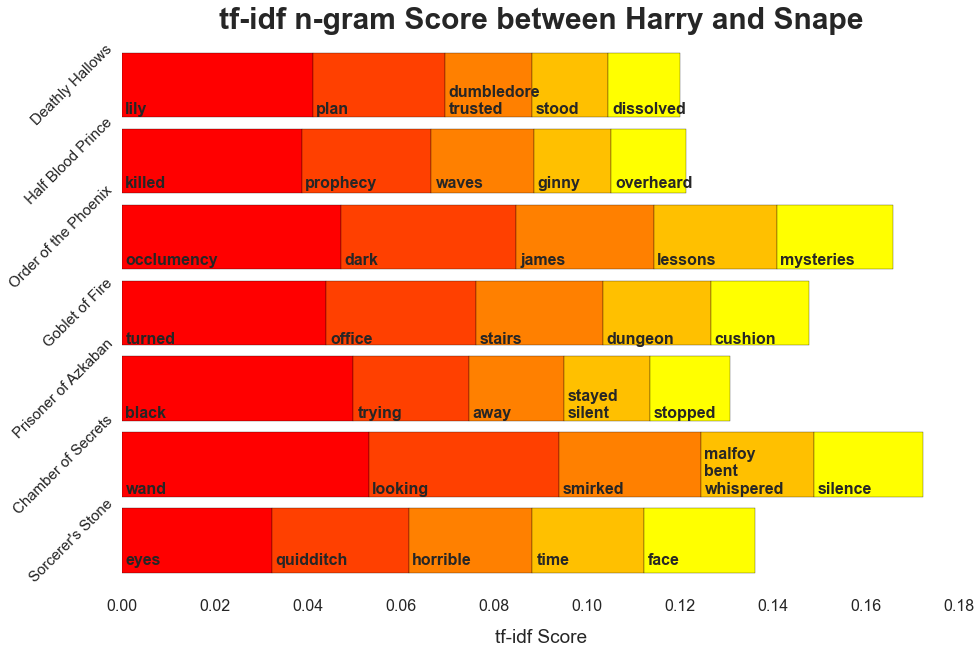

In [591]:
from matplotlib import cm
ax = goodwords.plot(kind='barh',stacked=True,figsize=(15,10),yticks=range(7),
                  fontsize=16,legend=False,cmap=plt.cm.autumn,width=0.85)
ax.set_yticklabels(["Sorcerer's Stone",'Chamber of Secrets','Prisoner of Azkaban','Goblet of Fire',
                    'Order of the Phoenix','Half Blood Prince','Deathly Hallows'],rotation=45,fontsize=15)
ax.set_axis_bgcolor('white')
ax.set_xlabel('tf-idf Score',fontsize=19)
ax.set_title('tf-idf n-gram Score between Harry and Snape',fontsize=30,weight='bold')
ax.xaxis.labelpad = 15

for i, label in enumerate(l0):
    ax.annotate(label, (goodwords.iloc[0,:i].sum()+0.0009,-0.32),fontsize=16,weight='bold')
for i, label in enumerate(l1):
    ax.annotate(label, (goodwords.iloc[1,:i].sum()+0.0009,.62),fontsize=16,weight='bold')
for i, label in enumerate(l2):
    ax.annotate(label, (goodwords.iloc[2,:i].sum()+0.0009,1.62),fontsize=16,weight='bold')
for i, label in enumerate(l3):
    ax.annotate(label, (goodwords.iloc[3,:i].sum()+0.0009,2.6),fontsize=16,weight='bold')
for i, label in enumerate(l4):
    ax.annotate(label, (goodwords.iloc[4,:i].sum()+0.0009,3.635),fontsize=16,weight='bold')
for i, label in enumerate(l5):
    ax.annotate(label, (goodwords.iloc[5,:i].sum()+0.0009,4.65),fontsize=16,weight='bold')
for i, label in enumerate(l6):
    ax.annotate(label, (goodwords.iloc[6,:i].sum()+0.0009,5.62),fontsize=16,weight='bold')

#### Generating topics (using LDA) on the text where 2 characters appear together:

In [603]:
def get_topics(book,name1,name2):
    for chap in range(len(books[book])):
        if get_positions(book,chap,name1,name2)!=(0,0):
            words = get_positions(book,chap,name1,name2) 
            vectorizer = CountVectorizer(stop_words = "english")
            doc_vecs = vectorizer.fit_transform(words)
            vocab = vectorizer.get_feature_names()

            model = lda.LDA(n_topics=4, n_iter=300,random_state=1)
            model.fit(doc_vecs)
            topic_word = model.topic_word_  
            doc_topic=model.doc_topic_
            n_top_words = 10

            for i, topic_dist in enumerate(topic_word):
                topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
                print('Book {} Chapter {} Topic {}: {}'.format(book+1, chap+1, i+1, ' '.join(topic_words)))

Topics selected that adequately represent interactions/theme between Harry and Snape:

In [36]:
b1topics = ['','','','','','','snape talking asked looking teaches \n doesnt potions got painfully struggled',
          'snape said know idea like professor \n wrong think quite dislike',
          'snape glasses speak father quidditch \n slytherin hear staring decent joking',
         'professor troll points youre white \n mind fury cold standing sat',
         'harry snapes face shut bandages \n knocked quickly gulped nerves read',
         'snape ron mirror know room library \n tonight close got better',
         'ron hermione stone didnt theyd \n little severus possibly hed torture',
         'snape yeah knows hagrid spell \n beamed spose ive temper sweeping',
         'harry ron paced waiting quirrell \n time heard didnt promised gambled',
          'hermione ron came didnt dont \n wailed idea thats eyes turned',
         'snape quirrell away make possession \n happened sent things used fathers']
b2topics = ['missed wizard classes snape secret \n witchcraft wizardry stomachache castle hogwarts','','','',
          'snape said house black cold fairer \n train deep sidekick strict','','','',
         'harry potions office hurried fast \n severus sense thumping darkened friends','',
         'harry looking floor face professor \n ear neville closer snapes turned','',
         'harry riddle door temper pulled \n hand school sitting pushed bacon',
         'snape activity moment wandered \n seen harry noise guard thankfully corridors',
         'snape ron dean rear pruning \n professor patch sprout marched going',
         'said lockhart looking teach \n dumbledore chamber notice hatred flew shall','','']
b3topics = ['detention holiday nasty spellbooks \n years street broomstick cauldron garden seized','','','',
         'snape anger startled twisting \n hissed ron time teachers best eyes','',
         'said malfoy potion didnt ingredients \n wouldnt sir looked corner great',
         'snape goblet grindylow cauldronful \n didnt showing wandering backed room black',
         'professor sit didnt severus got \n expect eyes hes late dungeons',
         'malfoy crocodile dementor hit \n harry snape spent falling caused class',
         'ron large mcgonagall looking \n years topped year gunshot noisemaker reluctantly',
         'finishing seriously hermione \n essay remind undetectable half row getting magical','',
         'snape said didnt hogsmeade \n snapes know hed inside silent say','',
         'told head sank cloak confusing \n low sit pretense potions opportunity','',
         'harry sirius doesnt got \n quidditch didnt disliked jamess looked led',
         'black potter peter wasnt door \n killed shouted looking sirius finish',
         'snape pettigrew said abruptly \n flung wand arm lolling sirius drift',
         'minister dumbledore make sirius \n madam look dementors dont havent know',
         'snape harry shrieked pointing \n behavior saved staircase dont listened failing']
b4topics = ['','','','','','','','','','','',
          'snape harrys matched possible \n loathing hogwarts table large sinistras hat',
         'snape air dungeons marched moments \n fallen chat harry growled friend',
         'moody arts snapes mealtimes overt \n really shown job wary scared',
         'said snape cedric thing writing \n harry month ill hufflepuff horrors','',
         'snape watching ask impatient \n calmly disbelief ignoring asked went right',
         'snape knew test stinks sight \n table looking brew curse glittering','',
         'harry snape unprepared worst \n slightly enemy emerging dragons arent turned','',
         'harry potter arrived bent throwing \n supposed crossing delinquent hes itll',
         'snape harry snarled went goatee \n black billowing whats slightly wand','',
         'harry stairs potter straight \n crouch slowly norris theres closed avoid',
         'said loathed ron landed flew \n school kill saving thing banished',
         'snape said snapes potion eyes \n look beetles turned saw stolen',
         'harry crouch forest professor \n right mind angrily denying smile way',
         'snape mouse hunting potter \n returning wanted whats beak trouble headmaster',
         'harry matter know angry tone \n stopped wanted strongly personal lord',
         'harry saw thoughts talking night \n stared evening hands minutes reeling','','','',
         'harry professor potter map eyes \n father wand place hair lying',
         'said spoke finally severus \n wordlessly swept watched dog slightly need',
         'harry difficult unpleasant away \n returned professor karkaroff madame hagrid truly']
b5topics = ['','','','snape door professor ron cautiously \n told head string dammit thank','',
         'snape attempt sneak conversation \n recalled flitted gleaned weasley glimpses brief','','','','','',
         'harry taunt cauldron class draught \n face laughed slytherins yes loved',
         'staircase possibility ron fell \n right walked answers dawned lurking saw','',
         'harry drowning dreaming desperately \n date ok add essay looking questioned',
         'said youd defence arts frowned meant \n kind snape ron threatening',
         'harry potter class oh seats \n copies detention burned dropped fungi','',
         'want ive hand slytherin quite \n hit time believe refused match','','','','',
         'snape know lord lessons think \n black attempt ron let cold',
         'snape trying harrys isnt \n corridor inside snappishly open dreams door',
         'said potter dark snapes looking \n repeated evenings voice liquid blinked',
         'harry professor trouble terrible \n cut started da expulsion save word',
         'snapes hard looking looked moved \n right sir heart floor mind',
         'said james yeah ok eyes pretty \n bit didnt understand going',
         'snape sank ask dramatic hear \n think talk truthfully ended reason',
         'ooclumency potions thoroughly \n tense proceedings sitting classes tables seen dreadful',
         'harry shouted wish cried hand \n tell walking bow voldemorts school','','','','',
         'harry sirius lessons hurt explained \n yelled voldemort pleasure spat easier',
         'snape felt rush rang leading \n coldly fingers knows away fell']
b6topics = ['','snape murdered sorcerers narcissa \n high pocket prophecy reasons dumbledores sat','',
         'harry think asked say slightly \n thought yes ought potions silence','','','',
         'harry hall minutes dark gateau \n bumped slughorn flying bursting torment',
         'snape repel thought nonverbal \n gaze face raised reacted speaking strong',
         'awkwardly snape began evening \n sit instead belt enjoyable door headmistresses',
         'snape detention ive im yes \n bustled hopefully got postponed moment',
         'snape said use professor told \n levicorpus woken hand effective gave',
         'snape pomfrey knows arts dark \n yes mungos katie asked hopeful','',
         'snape like way investigating \n looking seen wanted better certain low',
         'said pretending dumbledore saying \n trust offering malfoy times saw dad',
         'harry professor party sat glaring \n suggest answer finished speak silence',
         'harry lesson throats teacher \n flitwick bent colourless sparing slytherin instructor',
         'snape heard slytherins lost care \n hard bit shuffled urged seat','',
         'harry hermione room essay prince \n finally expected low marks stupid','','',
         'snape book nickname copy eyes \n stomach know liar firmly close',
         'harry prophecy face saturday \n time looked james long waves good',
         'healed said snape silver time \n leaving merely fade raised younger',
         'harry said dumbledore time \n professor experienced fell stop doesnt didnt',
         'harry snape killed dumbledore \n hagrid death yelled malfoy uncomprehending gone',
         'said pomfrey death eaters james \n fault dead came believed chair',
         'snape evil knew bed seeing \n quietly sleeping sleep telling managed']
b7topics = ['voldemort said place assure \n table controlled body went mistrust shall',
          'dumbledores scene doubt hogwarts \n legion read fell leads castle severus','','',
         'snape george snapes say stan \n broom flying hes hushed kindly',
         'snape place using insane knives \n maneuver protection set shaky talk','','',
         'making hermione like really \n took scare house worked time curtains',
         'snape information phineas way \n thought looking contained hed handed gaze',
         'said reckon yes tell hes curse \n make figure raising rose',
         'snape know friends killed room \n good accept mcgonagall newspaper dumbledores','','',
         'snape harry nigellus professor \n told pacing idiot eccentricities sudden important',
         'ideal informer kind glad ginny \n gatherings reinstated impertinent controlled hard','','','','','',
         'asked wouldnt fact lulled putting \n feel security country want false',
         'bared dare gripped release gaze \n snape forced harry thing tightly',
         'snape said moaned possess lake \n shortly path dumbledore grief black','','',
         'snape ron hermione caught hogwarts \n killings seen scrambling getting warning',
         'limping die lookout frowning picture \n hermione isnt taller charge deputies',
         'dumbledore secrets thought albus \n natural fast telling course means army',
         'mcgonagall wand thought looked \n heard happened touch believed swiftness balance',
         'professor hermione shouted relief \n dirty large ran corner stay chamber',
         'harry wand left air voice think \n silvery reassure pulled trying',
         'snape said boy little asked eyes \n youre tunnel dissolved saw',
         'snape home girl kneeling injured \n huge holding harry hand ginny',
         'didnt end meant moaned time \n gradually happen work intended bit',
         'dumbledores voldemort chose \n plan truly ago deathstick destiny saw try']
booktopics = [b1topics,b2topics,b3topics,b4topics,b5topics,b6topics,b7topics]

#### Creating a "rolling mean" for sentiment scores to establish a timeline showing sentiment and topics each chapter:

In [37]:
df = pd.DataFrame(sentiment,columns=['score'])
df['rolling'] = pd.rolling_mean(df['score'],window=35,min_periods=1,center=True)
df.to_csv('test.csv')

In [38]:
alltopics = []
alltopics.extend(t for t in booktopics)
alltopics = [x for y in alltopics for x in y]
alltopics = [str(i) for i in alltopics]
alltopics = ['No interaction' if x=='' else x for x in alltopics]

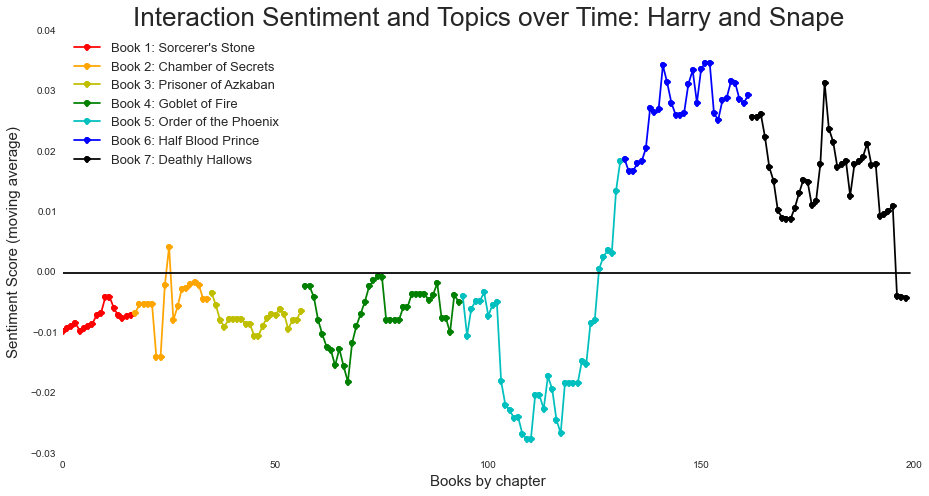

In [43]:
lens = [0, 17, 35, 57, 94, 132, 162, 199]

fig = plt.figure(figsize=(13, 7))
ax = fig.add_subplot(1, 1, 1)
ax.set_axis_bgcolor('white')
y = list(df['rolling'])
ax.set_title('Interaction Sentiment and Topics over Time: Harry and Snape',fontsize=26)
ax.set_xlabel('Books by chapter',fontsize=15)
ax.set_ylabel('Sentiment Score (moving average)',fontsize=15)
colors=['r','orange','y','g','c','b','k']
booklist=["Book 1: Sorcerer's Stone","Book 2: Chamber of Secrets","Book 3: Prisoner of Azkaban","Book 4: Goblet of Fire",
          'Book 5: Order of the Phoenix',"Book 6: Half Blood Prince","Book 7: Deathly Hallows"]
for i in range(1,8):
    lines=ax.plot(range(lens[i-1],lens[i]),y[lens[i-1]:lens[i]],marker='o',c=colors[i-1],label=booklist[i-1])
    mpld3.plugins.connect(fig, mpld3.plugins.PointLabelTooltip(lines[0],labels=alltopics[lens[i-1]:lens[i]+1],voffset=20,hoffset=30))
ax.plot(range(200),[0]*200,'-',color='k')
ax.yaxis.grid()
ax.yaxis.labelpad = 10
plt.legend(loc="upper left",prop={'size':13})
plt.tight_layout()
#mpld3.display()
mpld3.enable_notebook()
#print (mpld3.fig_to_html(fig,use_http=True))